# Fitting the HB/RGB Ratio for Globular Clusters

This notebook goes through the procedure for fitting the HB/RGB ration in globular clusters. It utilizes the data from [Salaris et al. (2004)](https://arxiv.org/abs/astro-ph/0403600) and goes into the axion constraints from [Ayala et al. (2014)](https://arxiv.org/abs/1406.6053).

There are two goals of this notebook:
* To check that we are using the right data by reproducing the results of Ayala et al. (2014)
* To perform a slightly more sophisticated statistical analysis of the data from Salaris et al. (2004)

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import pylab as plt

In [2]:
data = np.genfromtxt('data/gc-hb-rgb.txt',names=True,dtype=None)
# Select metal-poor clusters
d = data[data['feh_gc97'] <= -1.1]

weights = 1./d['sigma']**2
wavg = np.average(d['R'],weights=weights)
wavg_err = 1./np.sqrt(np.sum(weights))

label = "R_avg = %.2f +/- %.2f"%(wavg,wavg_err)
print(label)

R_avg = 1.39 +/- 0.03


The value $R_{\rm avg} = 1.39 \pm 0.03$ is exactly what is used by Ayala et al. (2014) to set their axion constraints. This gives us confidence that we are using the same data with the same cuts that they were using.

In [3]:
def draw_data():
    plt.errorbar(x=d['feh_gc97'],y=d['R'],yerr=d['sigma'],marker='o',ls='',ms=6, capthick=2,elinewidth=2,capsize=5,mfc='w',c='k',mew=1.5)
    plt.ylabel(r'${\rm Ratio\ (N_{HB}/N_{RGB})}$',fontsize=18)
    plt.xlabel(r'${\rm [Fe/H]}$',fontsize=18)
    plt.xlim(-2.2,-1.0)

def draw_wavg():
    plt.axhline(wavg,c='gray',ls='-',lw=1.5,label=label)
    plt.axhline(wavg+wavg_err,ls='--',c='gray',lw=1.5,zorder=-1)
    plt.axhline(wavg-wavg_err,ls='--',c='gray',lw=1.5,zorder=-1)
    plt.xlim(-2.2,-1.0)


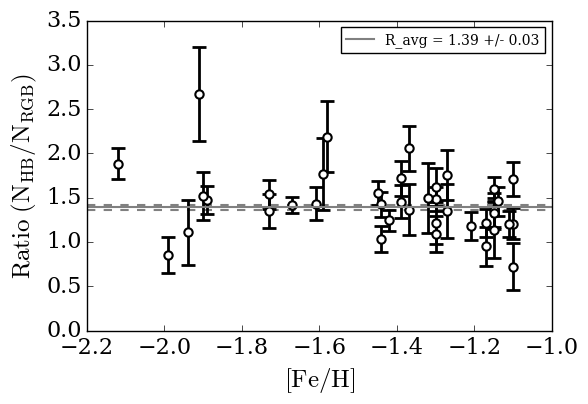

In [4]:
plt.figure()
draw_data()
draw_wavg()
plt.legend()

This plot shows that the uncertainty in the weighted average is much smaller than the cluster-to-cluster scatter. In effect, the weighted average should be an estimate of the overall Poisson errors on the mean coming from calculating the R = HB/RGB from the stellar populations of all clusters combined. It would be nice to have access to have the raw HB and RGB counts in each cluster to be able to reproduce this calculation from the raw data themselves.

In reality, it would be nice to apply some more sophisticated statistical techniques to estimate the uncertainty on the ratio R. To do this correctly, it would be best to have the raw star counts. In the meantime, we can test for the consistency of a single value of R for all GCs, we perform a maximum likelihood fit to R as a function of [Fe/H].

In [5]:
import scipy.optimize as op

In [6]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [7]:
x = d['feh_gc97']
y = d['R']
yerr = d['sigma']
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [0, 1.39, np.log(0.5)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

print m_ml,b_ml,lnf_ml

-0.248484952891 1.04595145289 -2.16933272635


In [8]:
def draw_fit(m,b,lnf,**kwargs):
    x = np.linspace(-1.0,-2.2,50)
    y = m*x + b
    plt.plot(x,y,'-',label=r'${\rm R_{avg} = %.2f [Fe/H] + %.2f}$'%(m,b),**kwargs)
    plt.xlim(-2.2,-1.0)

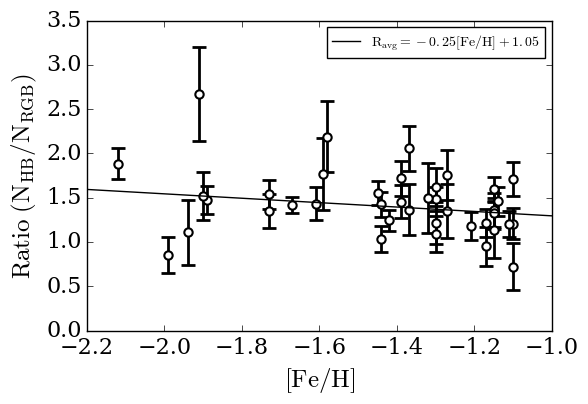

In [9]:
plt.figure()
draw_data()
draw_fit(m_ml,b_ml,lnf_ml)
plt.legend()

So the maximum likelihood fit perfers a small slope, but is this slope statistically significant?

In [10]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [11]:
import emcee
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [12]:
ret = sampler.run_mcmc(pos, 500)

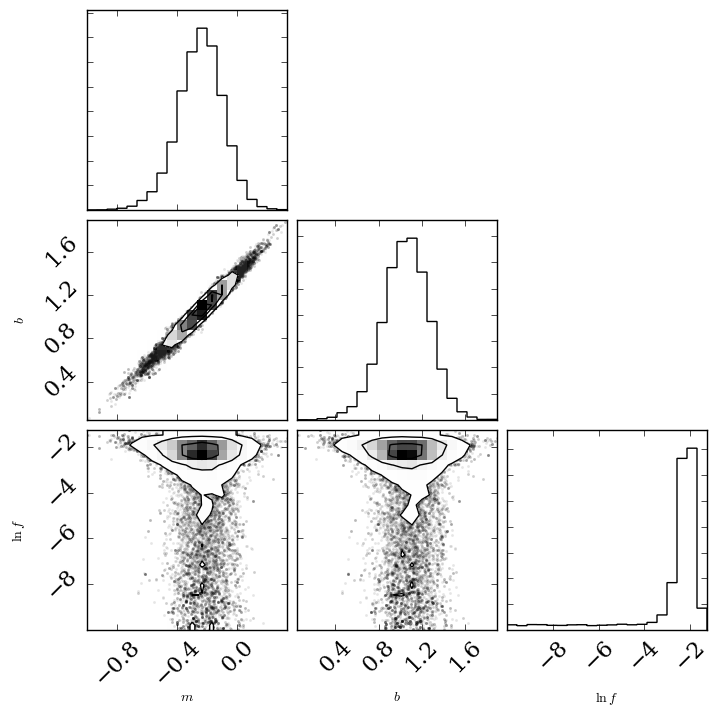

In [13]:
import corner
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"])

In [14]:
def draw_mcmc():
    xl = np.linspace(-2.2,-1.0,10)
    for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(xl, m*xl+b, color="k", alpha=0.1)



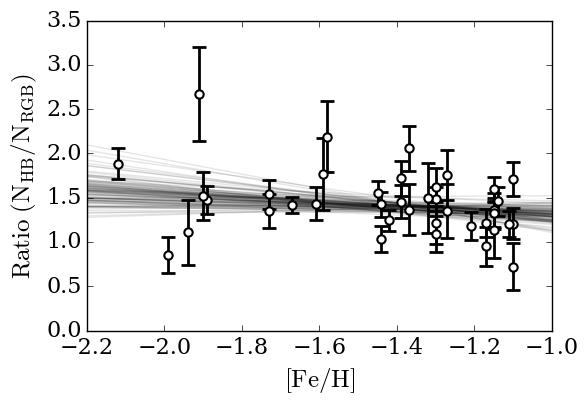

In [15]:
plt.figure()
draw_mcmc()
draw_data()

In [16]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print('m = %.2f [+%.2f, -%.2f]'%m_mcmc)
print('b = %.2f [+%.2f, -%.2f]'%b_mcmc)

m = -0.24 [+0.14, -0.15]
b = 1.06 [+0.20, -0.21]


In [17]:
float((samples[:,0] > 0).sum())/len(samples[:,0])

0.04415

Going back simplistic statistics (assuming a gaussian posterior), we can estimate that the data from Alaya et al. 2004 are inconsistent with $m = 0$ at $(0.24/0.14) = 1.7\sigma$. This suggests that the Ayala et al. (2014) data slightly prefer a non-zero slope (as was obvious from looking at the data in the first place). We could make a more Bayesian estimate for the significance of a slope by calculating the Bayes factor at $m = 0$, but this seems like overkill for this notebook...